# 1. Template Notebook

Create a jupyter notebook template to do the following - for a given token and date range:
- calculate the hourly return by timestamp
- calculate the hourly volatility (you can use the formula we went over in class)
- calculate maximum drawdown up to that hour for each hour
- then plot in a 2x2 grid:
    - hourly return
    - hourly vol
    - maximum drawdown
    - close prices
    - color each day on the graph

In [1]:
import numpy as np
import pandas as pd 
import sqlite3
import gspread
import scrapbook as sb

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.dates import date2num, DateFormatter
from pandas.plotting import scatter_matrix

plt.style.use('ggplot')
plt.tight_layout()
plt.rcParams['figure.figsize'] = [20, 20]

%matplotlib inline

/Users/anhpham/opt/anaconda3/envs/mfe-preprogram/lib/python3.8/site-packages/papermill/iorw.py:50: FutureWarning: pyarrow.HadoopFileSystem is deprecated as of 2.0.0, please use pyarrow.fs.HadoopFileSystem instead.
  from pyarrow import HadoopFileSystem


In [2]:
%%capture
%load_ext sql
%sql sqlite:///data/data.db

In [3]:
conn = sqlite3.connect('data/data.db')
cur = conn.cursor()

In [4]:
# Check the available tables in db
for row in cur.execute('SELECT name FROM sqlite_master'):
    print(row)

('ohlc',)
('market_caps',)


In [5]:
%%sql 

SELECT max(ts) FROM ohlc WHERE token = token LIMIT 10

 * sqlite:///data/data.db
Done.


max(ts)
2021-12-15 00:00:00


In [6]:
#params
token = 'BTC'
from_date = '2021-12-01'
to_date = '2021-12-15'
connection_string = 'sqlite:///data/data.db'
events_db = 'crypto_events_database'

In [7]:
# Parameters
from_date = "2021-12-03 00:00:00"
to_date = "2021-12-10 00:00:00"
token = "DOT"
connection_string = "sqlite:///data/data.db"
events_db = "crypto_events_database"


In [8]:
coin_result = pd.read_sql(f'''
SELECT
*
FROM ohlc
WHERE 
    token = '{token}'
    AND ts >= '{from_date}'
    AND ts < '{to_date}'
''', connection_string
)

coin_result['ts'] = pd.to_datetime(coin_result['ts'])
coin_result.set_index('ts', inplace=True)

In [9]:
#1.1 calculate the hourly return by timestamp
def calc_return(df):
    return df.assign(hourly_return=
                     np.log(df.close/ df.close.shift(1)))

In [10]:
#1.2 calculate the hourly volatility 
def vol_ohlc(df, lookback=10):
    o = df.open
    h = df.high
    l = df.low
    c = df.close
    
    k = 0.34 / (1.34 + (lookback+1)/(lookback-1))
    cc = np.log(c/c.shift(1))
    ho = np.log(h/o)
    lo = np.log(l/o)
    co = np.log(c/o)
    oc = np.log(o/c.shift(1))
    oc_sq = oc**2
    cc_sq = cc**2
    rs = ho*(ho-co) + lo*(lo-co)
    close_vol = cc_sq.rolling(lookback).sum() * (1.0 / (lookback - 1.0))
    open_vol = oc_sq.rolling(lookback).sum() * (1.0 / (lookback - 1.0))
    window_rs = rs.rolling(lookback).sum() * (1.0 / (lookback - 1.0))
    result = (open_vol + k * close_vol + (1-k) * window_rs).apply(np.sqrt) * np.sqrt(252)
    result[:lookback] = np.nan
    
    return df.assign(volatility=result)

In [11]:
# 1.3 calculate maximum drawdown up to that hour for each hour


def calc_mdd(df):
    MDD = 0
    MDD_s = pd.Series(dtype='float64')
    start = df.index[0]
    
    for i in df.index:
        max_close = max(df.loc[start:i, 'close'])
        DD = (df.loc[i,'close']-max_close)/max_close
        if DD < MDD:
            MDD = DD
        MDD_s.loc[i] = MDD
    
    return df.assign(MDD=MDD_s)


In [12]:
coin_prices = calc_return(coin_result)
coin_prices = vol_ohlc(coin_prices,2)
coin_prices = calc_mdd(coin_prices)

In [13]:
coin_prices

,open,high,low,close,volume,volumeUSD,token,chain,hourly_return,volatility,MDD
ts,,,,,,,,,,,
2021-12-03 00:00:00,36.092,36.156,35.711,35.791,67825.032,2.434838e+06,DOT,DOT,NaN,NaN,0.000000
2021-12-03 01:00:00,35.790,35.963,35.677,35.774,69768.674,2.498266e+06,DOT,DOT,-0.000475,NaN,-0.000475
2021-12-03 02:00:00,35.760,35.950,35.640,35.832,74789.106,2.678066e+06,DOT,DOT,0.001620,0.127403,-0.000475
2021-12-03 03:00:00,35.840,36.134,35.189,35.340,101373.758,3.621485e+06,DOT,DOT,-0.013826,0.269272,-0.013731
2021-12-03 04:00:00,35.343,35.701,35.300,35.557,68568.203,2.433660e+06,DOT,DOT,0.006122,0.276459,-0.013731
...,...,...,...,...,...,...,...,...,...,...,...
2021-12-09 19:00:00,27.470,27.696,27.025,27.235,219528.362,6.008394e+06,DOT,DOT,-0.008009,0.304497,-0.305368
2021-12-09 20:00:00,27.248,27.486,27.092,27.286,143041.075,3.908051e+06,DOT,DOT,0.001871,0.295040,-0.305368
2021-12-09 21:00:00,27.284,27.365,26.804,27.117,157747.514,4.263461e+06,DOT,DOT,-0.006213,0.281575,-0.305368


In [14]:
'''
Plot in a 2x2 grid:
- hourly return
- hourly vol
- maximum drawdown
- close prices
- color each day on the graph
'''

def series_plot(data, events=None, ax=None):
    data.plot(ax=ax)
    
    start_of_days = data.between_time('00:00:00','00:00:00').index.to_list()
    end_of_days = start_of_days[1:] + [data.index[-1]]
    colors = iter(cm.rainbow(np.linspace(0,1, len(start_of_days))))
    
    for x, y in zip(start_of_days, end_of_days):
        color = next(colors)
        ax.axvspan(x, y, color = color, alpha=0.1)
        
    if events is not None:
        ymin, ymax = ax.get_ylim()
        text_pos = 1

In [15]:
%%capture

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(20,20))

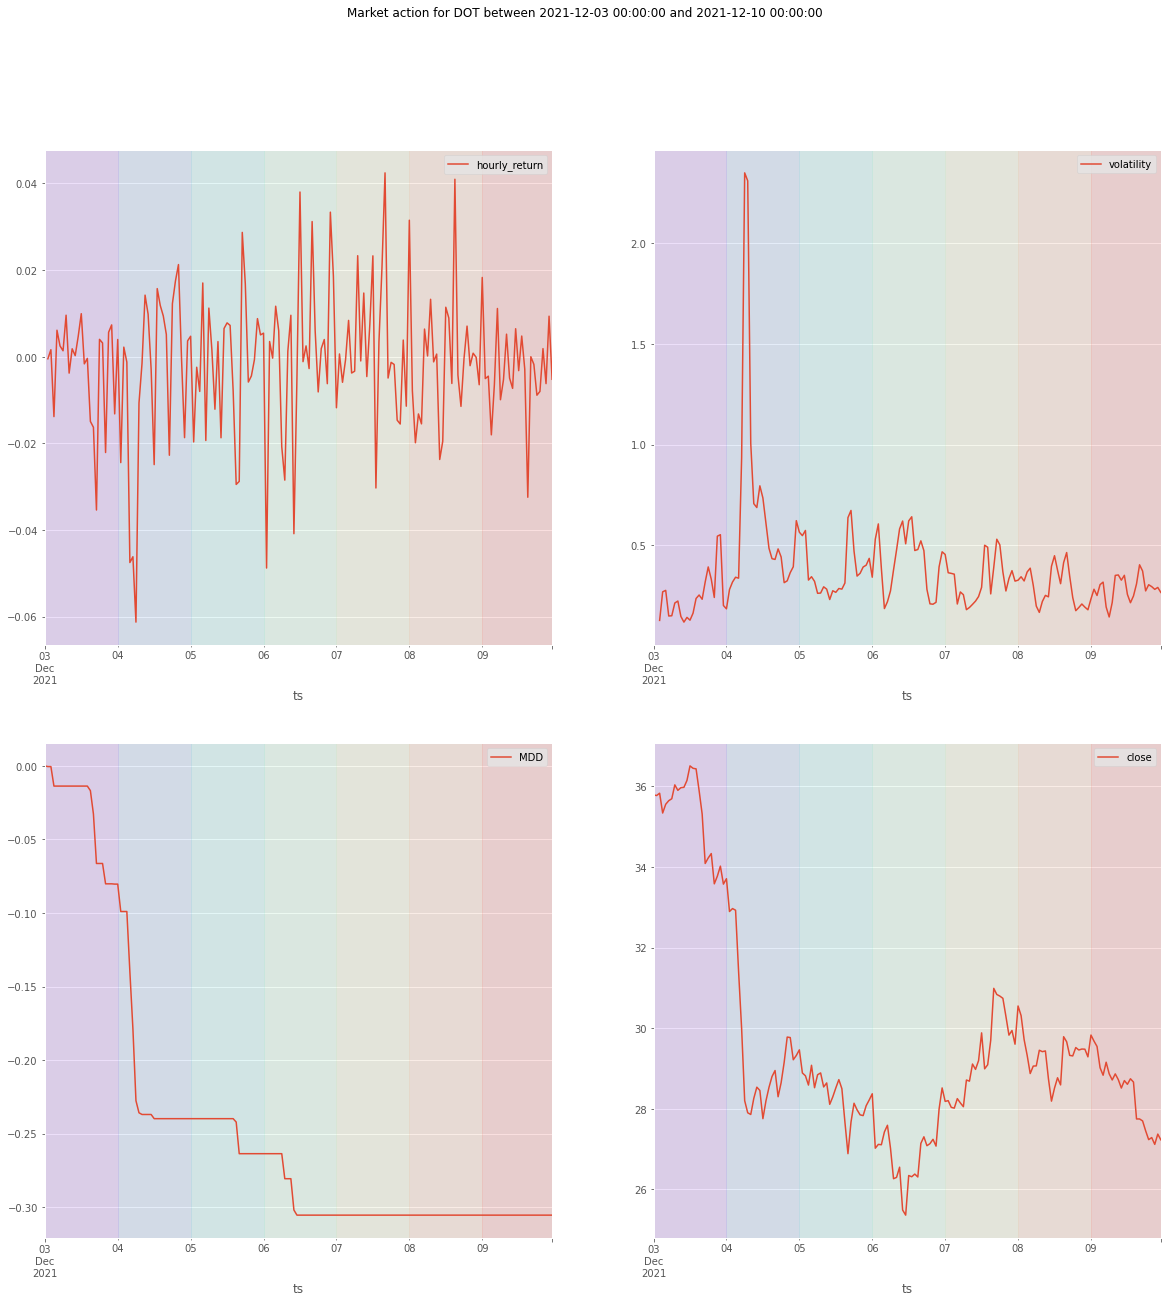

In [16]:
series_plot(coin_prices[['hourly_return']], ax=ax[0,0])
series_plot(coin_prices[['volatility']], ax=ax[0,1])
series_plot(coin_prices[['MDD']], ax=ax[1,0])
series_plot(coin_prices[['close']], ax=ax[1,1])

fig.suptitle(f'Market action for {token} between {from_date} and {to_date}')
fig

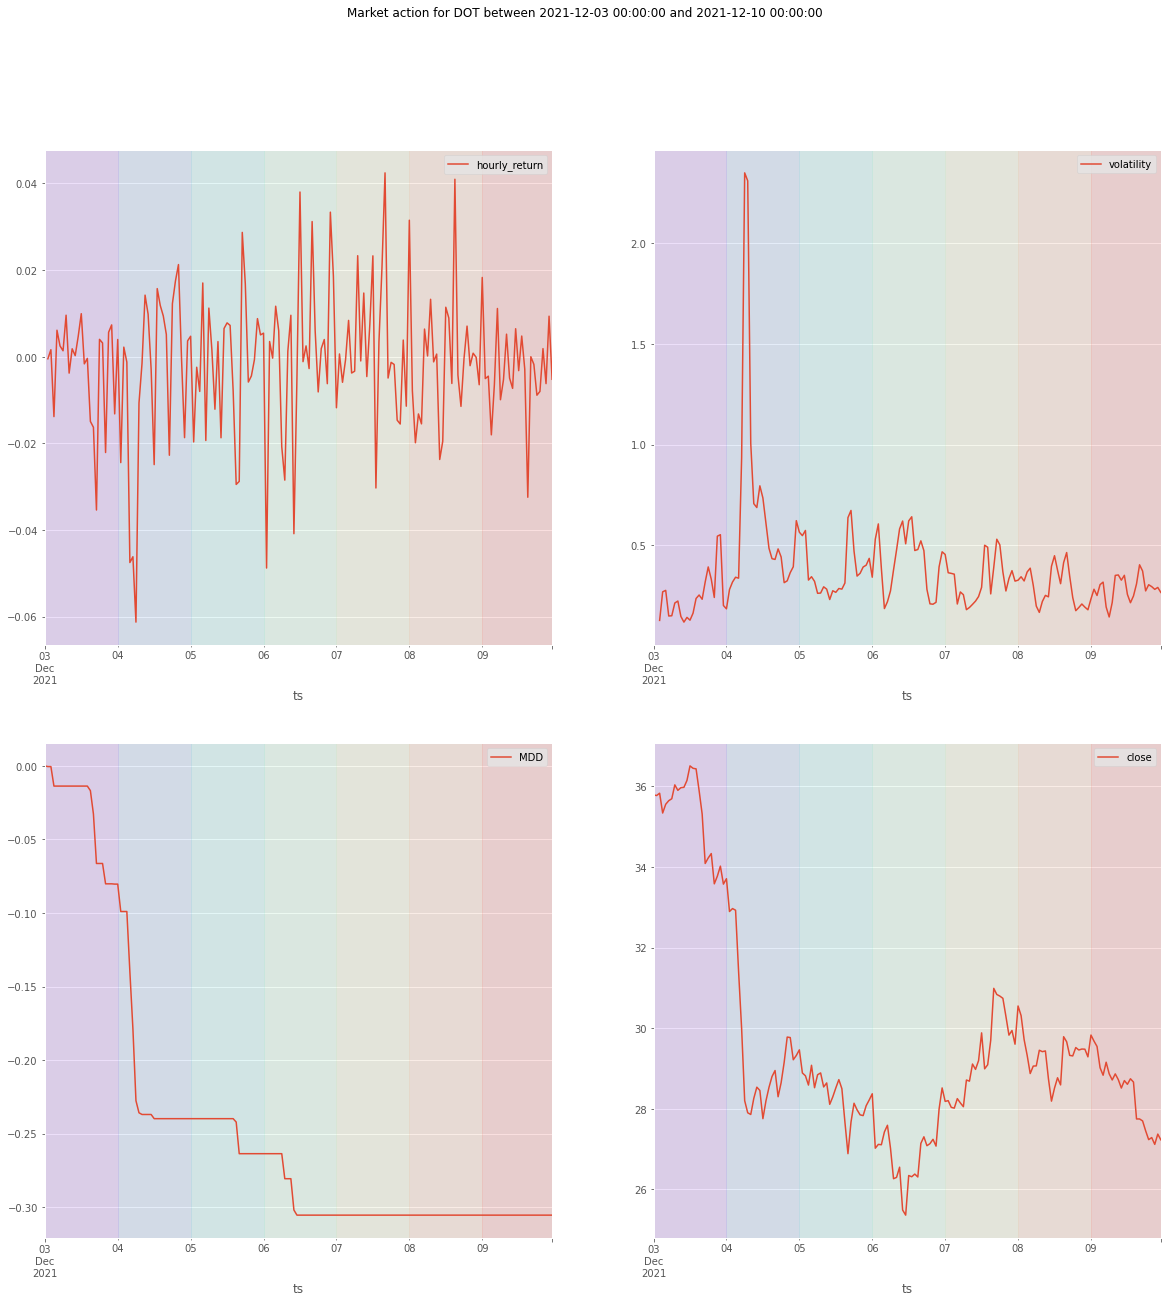

In [17]:
sb.glue('token', token)
sb.glue('from_date', from_date)
sb.glue('to_date', to_date)
sb.glue('prices', coin_prices, encoder='pandas')
sb.glue('summary_plot', fig, encoder='display', display=True)